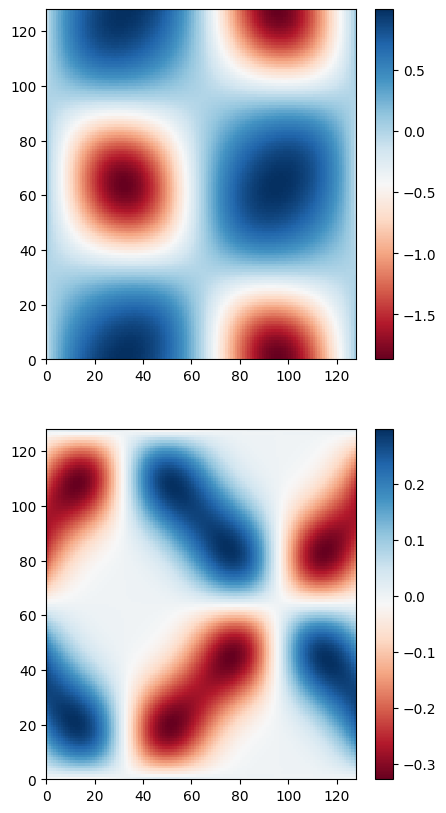

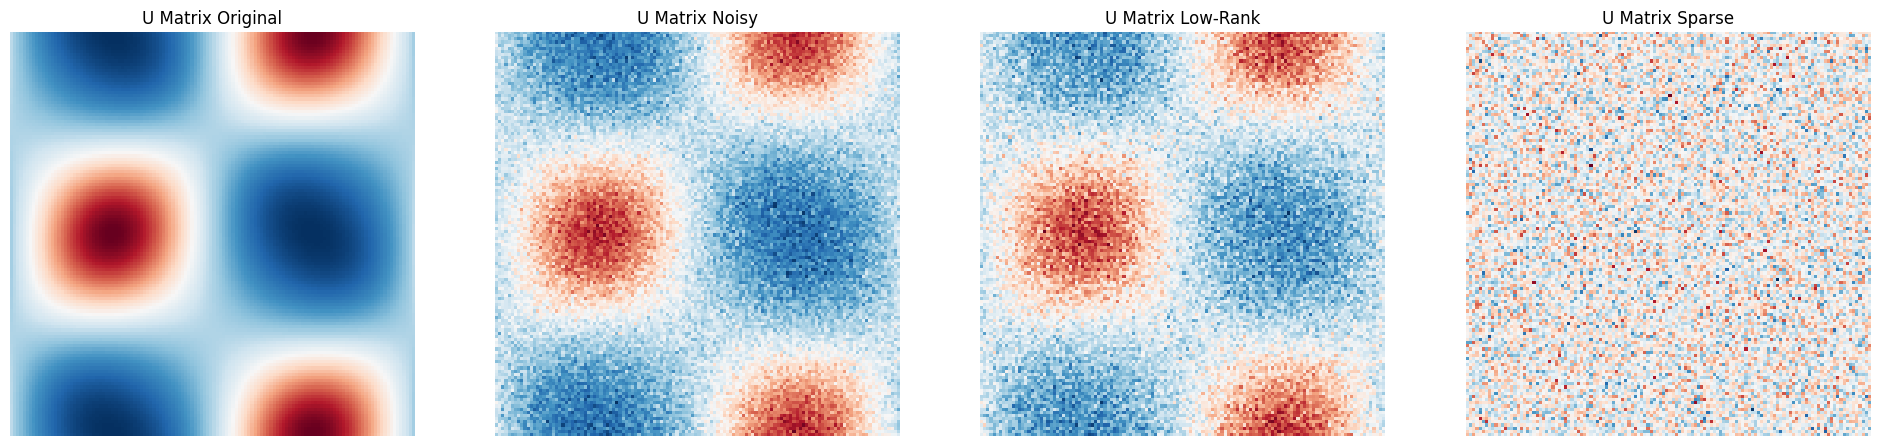

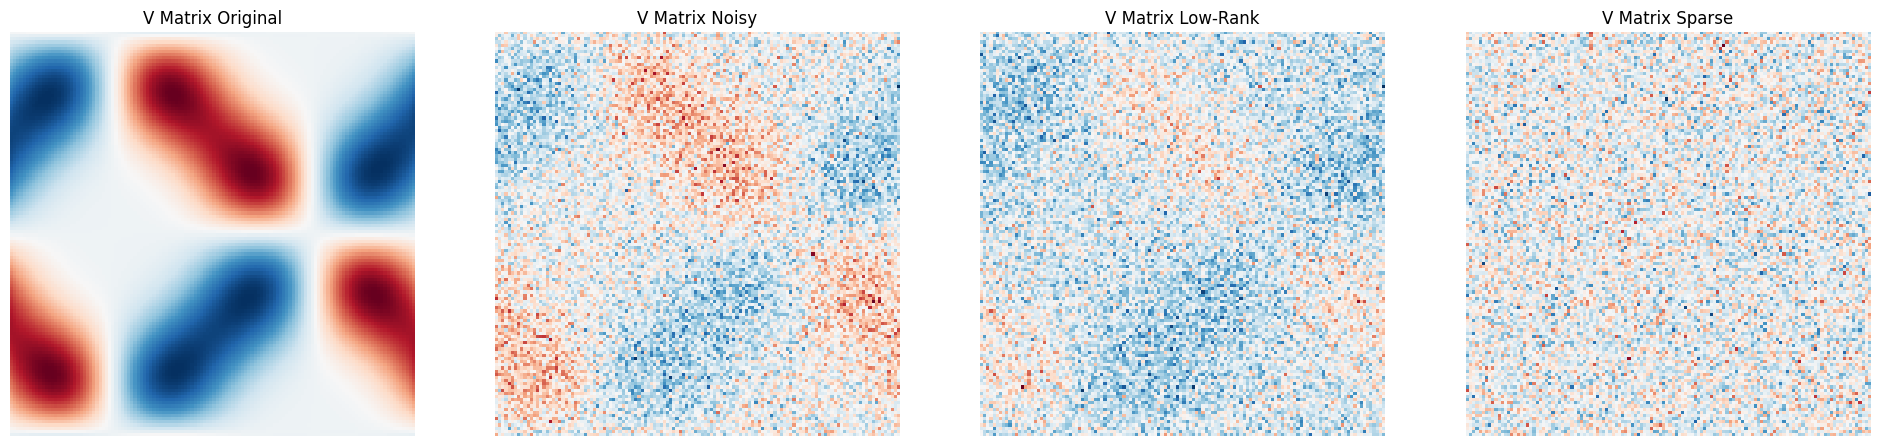

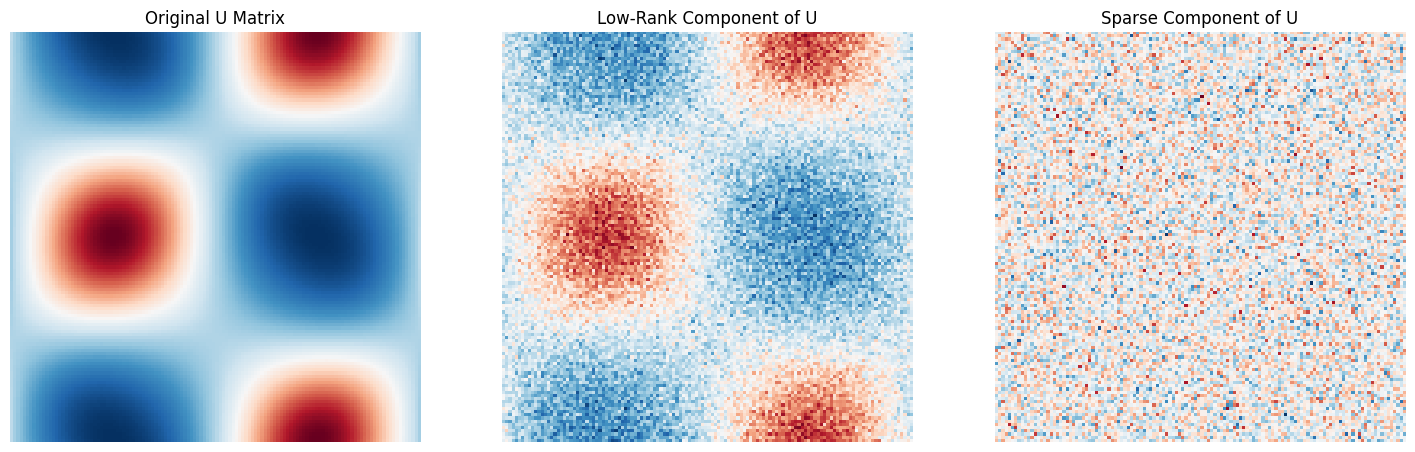

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Defining the reaction-diffusion model and other functions from before
def model_start(nx, ny):
    u_init = np.ones((nx, ny))
    v_init = np.zeros((nx, ny))

    x, y = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))

    pi = np.pi
    u_init = np.sin(2 * pi * x) * np.cos(2 * pi * y)
    v_init = np.cos(2 * pi * x) * np.sin(2 * pi * y)

    return u_init, v_init

#defining periodic_bc function to apply periodic boundary conditions to 'u'. This is for the grid to wrap around at edges
def periodic_bc(u):
    u[0, :] = u[-2, :]
    u[-1, :] = u[1, :]
    u[:, 0] = u[:, -2]
    u[:, -1] = u[:, 1]

#defining a fucntion to calculate the Laplacian using five-point stencil scheme(a finite difference approximation for the Laplace operator)
def five_point_scheme(u):
    """
    Five point scheme
    """
    return (                  u[ :-2, 1:-1] +
             u[1:-1, :-2] - 4*u[1:-1, 1:-1] + u[1:-1, 2:] +
                          +   u[2:  , 1:-1] )

#defining a function to integrate the model by computing Laplacians, introducing the reaction terms and updating 'u' and 'v' over time using the ultimate reaction-difussion equations.
def integrate_model(U, V, params):
    dt, Du, Dv, F, k = params

    u, v = U[1:-1, 1:-1], V[1:-1, 1:-1]

    Lu = five_point_scheme(U)
    Lv = five_point_scheme(V)

    u += dt * (Du * (Lu + (u - u**2 - u*v)))
    v += dt * (Dv * (Lv + (-v + u*v)))

    periodic_bc(U)
    periodic_bc(V)

# An array of parameters is passed to the integrators
params = np.array([0.5, 0.15, 0.55, 0.25, 0.62])

# Initializing the model
U, V = model_start(128, 128)

# Time-stepping loop which runs for 4 time steps to use the 'integrate_model' function in each iteration to simulate the evolution of 'u' and 'v' over time.
for t in range(4):
    integrate_model(U, V, params)

# Plotting the result
plt.figure(figsize=(5, 10))
plt.subplot(2, 1, 1)
plt.pcolormesh(U, cmap='RdBu')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.pcolormesh(V, cmap='RdBu')
plt.colorbar()
plt.show()

# Visualizing the results for both U and V matrices
def visualize_matrix_components(original, original_noisy, low_rank, sparse, title_prefix, nx, ny):
    fig, axes = plt.subplots(1, 4, figsize=(24, 6))

    # Original model data visualization
    axes[0].imshow(original, cmap='RdBu')
    axes[0].set_title(f'{title_prefix} Original')
    axes[0].axis('off')

    # Noisy original data visualization
    axes[1].imshow(original_noisy, cmap='RdBu')
    axes[1].set_title(f'{title_prefix} Noisy')
    axes[1].axis('off')

    # Low-rank component visualization
    axes[2].imshow(low_rank, cmap='RdBu')
    axes[2].set_title(f'{title_prefix} Low-Rank')
    axes[2].axis('off')

    # Sparse component visualization
    axes[3].imshow(sparse, cmap='RdBu')
    axes[3].set_title(f'{title_prefix} Sparse')
    axes[3].axis('off')

    plt.show()

# Simulating the Gray-Scott model, adding noise, and applying RPCA for U and V matrices
U, V = model_start(128, 128)
for t in range(4):
    integrate_model(U, V, params)

# Applying noise and RPCA separately for U and V
data_noisy_U = add_noise(U, noise_level=0.2)
low_rank_U, sparse_U = robust_pca(data_noisy_U.reshape(1, -1), lam=1.0, tol=1e-7, max_iter=100, noise_st=0.2)

data_noisy_V = add_noise(V, noise_level=0.2)
low_rank_V, sparse_V = robust_pca(data_noisy_V.reshape(1, -1), lam=1.0, tol=1e-7, max_iter=100, noise_st=0.2)

# Visualization for U matrix
visualize_matrix_components(U, data_noisy_U, low_rank_U.reshape(128, 128), sparse_U.reshape(128, 128), "U Matrix", 128, 128)

# Visualization for V matrix
visualize_matrix_components(V, data_noisy_V, low_rank_V.reshape(128, 128), sparse_V.reshape(128, 128), "V Matrix", 128, 128)

#Decomposing the original U matrix into low-rank and sparse components (could repeat for V if needed)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(U, cmap='RdBu')
axes[0].set_title('Original U Matrix')
axes[0].axis('off')

axes[1].imshow(low_rank_U.reshape(128, 128), cmap='RdBu')
axes[1].set_title('Low-Rank Component of U')
axes[1].axis('off')

axes[2].imshow(sparse_U.reshape(128, 128), cmap='RdBu')
axes[2].set_title('Sparse Component of U')
axes[2].axis('off')

plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Defining functions for Gray-Scott model simulation and data preprocessing

# Function to simulate Gray-Scott model and generate synthetic data
def gray_scott_model(nx, ny, num_steps, Du, Dv, F, k, dt, dx):
    # Initializing concentrations for U and V
    U = np.ones((num_steps, nx, ny))
    V = np.zeros((num_steps, nx, ny))

    # Initialing conditions
    x, y = np.meshgrid(np.linspace(0, 1, nx), np.linspace(0, 1, ny))
    pi = np.pi
    U[0] = np.sin(2 * pi * x) * np.cos(2 * pi * y)
    V[0] = np.cos(2 * pi * x) * np.sin(2 * pi * y)

    # Time-stepping loop
    for t in range(1, num_steps):
        # Laplacian using five-point stencil scheme
        Lu = (np.roll(U[t-1], -1, axis=0) + np.roll(U[t-1], 1, axis=0) + np.roll(U[t-1], -1, axis=1) + np.roll(U[t-1], 1, axis=1) - 4 * U[t-1]) / dx**2
        Lv = (np.roll(V[t-1], -1, axis=0) + np.roll(V[t-1], 1, axis=0) + np.roll(V[t-1], -1, axis=1) + np.roll(V[t-1], 1, axis=1) - 4 * V[t-1]) / dx**2

        # Reaction-diffusion equations
        dU = Du * Lu - U[t-1] * V[t-1]**2 + F * (1 - U[t-1])
        dV = Dv * Lv + U[t-1] * V[t-1]**2 - (F + k) * V[t-1]

        # Updating concentrations
        U[t] = U[t-1] + dt * dU
        V[t] = V[t-1] + dt * dV

    return np.stack((U, V), axis=3)

# Parameters for Gray-Scott model
nx = 128  # Number of grid points in x-direction
ny = 128  # Number of grid points in y-direction
num_steps = 100  # Number of time steps
Du = 0.16  # Diffusion rate for U
Dv = 0.08  # Diffusion rate for V
F = 0.035  # Feed rate
k = 0.06  # Kill rate
dt = 0.1  # Time step size
dx = 1.0  # Grid spacing

# Generating synthetic data
data = gray_scott_model(nx, ny, num_steps, Du, Dv, F, k, dt, dx)

#defining a function to preprocess data (e.g., feature scaling)
def preprocess_data(data):
    # Reshaping data to 2D matrix
    data_2d = data.reshape((num_steps, nx * ny * 2))

    # Performing feature scaling
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_2d)

    return data_scaled

# Preprocessing data
data_scaled = preprocess_data(data)

# Splitting data into training and testing sets
X_train, X_test = train_test_split(data_scaled, test_size=0.2, random_state=42)



# Defining machine learning models as a dictionary
models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'param_grid': {'model__fit_intercept': [True, False], 'model__positive': [True, False]}
    },
    'SVR': {
        'model': SVR(),
        'param_grid': {'model__C': [0.1, 1, 10], 'model__gamma': [0.1, 0.01, 0.001]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {'model__n_estimators': [50, 100, 200], 'model__max_depth': [None, 10, 20]}
    }
}

# Iteration over models and performing hyperparameter tuning and evaluation
for name, model_info in models.items():
    # Creating pipeline with preprocessing steps (scaling) and the current model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model_info['model'])
    ])

    # Performing hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, X_train[:, 0])  # Assuming the first column is the target variable (U)

    #Getting the suitable model
    best_model = grid_search.best_estimator_

    # Evaluating the model
    train_predictions = best_model.predict(X_train)
    test_predictions = best_model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(X_train[:, 0], train_predictions))
    test_rmse = np.sqrt(mean_squared_error(X_test[:, 0], test_predictions))

    print(f"Model: {name}")
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Training RMSE:", train_rmse)
    print("Testing RMSE:", test_rmse)
    print("\n")


Model: Linear Regression
Best Hyperparameters: {'model__fit_intercept': True, 'model__positive': True}
Training RMSE: 5.259100039897522e-16
Testing RMSE: 2.1924295601910606e-12


Model: SVR
Best Hyperparameters: {'model__C': 10, 'model__gamma': 0.001}
Training RMSE: 0.0933047261343698
Testing RMSE: 0.2012679686635447


Model: Random Forest
Best Hyperparameters: {'model__max_depth': 10, 'model__n_estimators': 50}
Training RMSE: 0.02000699062282746
Testing RMSE: 0.06185374135371016


